In [3]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

# BLACK WITHOUT FATHER

In [4]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'BL_woF'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
merged_controls = False
    
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [6]:
def find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    # sort dataframe pvalues of control vs fam and pick the first 20
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    df_sigareas = pd.DataFrame()
    for col in columns:
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col]<alpha]['area'].reset_index(drop=True)], axis=1)
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]
    return df_sigareas

In [7]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [8]:
def load_subject(subject, data_directory, threshold1, threshold2):
    file_suffix = 'cells' + str(threshold2) if subject[0] == 'BL36Fam' else 'cells' + str(threshold1)
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

In [9]:
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject=subject, 
#                                                                                                 data_directory=data_directory, 
#                                                                                                 threshold1=2000, 
#                                                                                                 threshold2=1500), 
#                                                                           vol=volumes, 
#                                                                           level=8) for subject in subjects}
# np.save('dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy', dict_results_across_mice)

In [10]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy', 
                                   allow_pickle=True).item()

In [132]:
subjects = list(dict_results_across_mice.keys())

In [133]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)


## Calculate number of cells

In [134]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [135]:
df_control_cell_count.set_index('area').sum()

BL17Control    46000
BL26Control    26060
BL23Control    51372
BL44Control    11031
BL41Control    41174
BL29Control    21639
BL20Control    51968
BL32Control    24572
dtype: int64

In [136]:
df_fam_cell_count.set_index('area').sum()

BL43Fam    21042
BL36Fam    15760
BL24Fam    22059
BL34Fam    24774
BL21Fam    42912
BL37Fam    25208
BL27Fam    37634
BL40Fam    32040
BL30Fam    16780
BL18Fam    50231
dtype: int64

In [137]:
df_unfam_cell_count.set_index('area').sum()

BL42Unfam    24109
BL35Unfam    20408
BL22Unfam    56797
BL39Unfam    28628
BL25Unfam    36691
BL38Unfam    64619
BL31Unfam    53989
BL28Unfam    59197
BL33Unfam    20302
BL19Unfam    88763
dtype: int64

In [138]:
df_control_cell_count.set_index('area').loc['Anterior olfactory nucleus']

BL17Control    510
BL26Control    126
BL23Control    868
BL44Control    451
BL41Control    433
BL29Control    521
BL20Control    849
BL32Control    374
Name: Anterior olfactory nucleus, dtype: int64

In [139]:
df_fam_cell_count.set_index('area').loc['Anterior olfactory nucleus']

BL43Fam     884
BL36Fam     248
BL24Fam     348
BL34Fam     453
BL21Fam    1720
BL37Fam     613
BL27Fam     892
BL40Fam    1197
BL30Fam     375
BL18Fam    1557
Name: Anterior olfactory nucleus, dtype: int64

In [140]:
df_unfam_cell_count.set_index('area').loc['Anterior olfactory nucleus']

BL42Unfam     843
BL35Unfam     844
BL22Unfam    1270
BL39Unfam     742
BL25Unfam    1645
BL38Unfam    2351
BL31Unfam     741
BL28Unfam    3225
BL33Unfam     465
BL19Unfam    2292
Name: Anterior olfactory nucleus, dtype: int64

In [141]:
df_unfam_cell_count.set_index('area').loc['Ventral premammillary nucleus']

BL42Unfam    140
BL35Unfam    196
BL22Unfam    234
BL39Unfam    116
BL25Unfam    147
BL38Unfam    169
BL31Unfam     20
BL28Unfam    153
BL33Unfam    212
BL19Unfam     11
Name: Ventral premammillary nucleus, dtype: int64

In [142]:
df_control_cell_count.set_index('area').loc['Supramammillary nucleus']

BL17Control    19
BL26Control    32
BL23Control    91
BL44Control    25
BL41Control    79
BL29Control    80
BL20Control    36
BL32Control    82
Name: Supramammillary nucleus, dtype: int64

In [143]:
df_fam_cell_count.set_index('area').loc['Supramammillary nucleus']

BL43Fam     44
BL36Fam     38
BL24Fam     11
BL34Fam     91
BL21Fam     51
BL37Fam     57
BL27Fam    123
BL40Fam    168
BL30Fam     10
BL18Fam    166
Name: Supramammillary nucleus, dtype: int64

In [144]:
df_unfam_cell_count.set_index('area').loc['Supramammillary nucleus']

BL42Unfam     57
BL35Unfam     25
BL22Unfam    126
BL39Unfam     85
BL25Unfam     76
BL38Unfam     96
BL31Unfam     12
BL28Unfam    115
BL33Unfam     83
BL19Unfam     26
Name: Supramammillary nucleus, dtype: int64

In [145]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count],
                                        test='mannwhitneyu')

In [146]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [147]:
df_ttest_not_null_ncells.set_index("area").loc['Piriform area']

pval_Control_vs_Fam       0.482282
pval_Control_vs_Unfam    0.0415816
pval_Fam_vs_Unfam        0.0378308
Name: Piriform area, dtype: object

In [148]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='n_cells',
                       test='mannwhitneyu',
                      alpha=0.05)

,Control_vs_Fam,Control_vs_Unfam,Fam_vs_Unfam
0,Accessory olfactory bulb,Cortical amygdalar area,Posterior amygdalar nucleus
1,Ventral premammillary nucleus,Ventral premammillary nucleus,Bed nuclei of the stria terminalis
2,Medial amygdalar nucleus,Accessory olfactory bulb,Septohippocampal nucleus
3,Main olfactory bulb,Posterior amygdalar nucleus,Nucleus of the brachium of the inferior collic...
4,Anteromedial nucleus,Medial amygdalar nucleus,Triangular nucleus of septum
5,Cortical amygdalar area,Periventricular hypothalamic nucleus posterior...,Piriform-amygdalar area
6,Perirhinal area,Piriform-amygdalar area,Intercalated amygdalar nucleus
7,Periventricular hypothalamic nucleus posterior...,Bed nuclei of the stria terminalis,Septofimbrial nucleus
8,Medial preoptic nucleus,Medial preoptic nucleus,Medial amygdalar nucleus
9,Magnocellular nucleus,Main olfactory bulb,Medial septal complex


In [149]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Accessory olfactory bulb,0.00124686
Ventral premammillary nucleus,0.00291432
Medial amygdalar nucleus,0.0033642
Main olfactory bulb,0.00566599
Anteromedial nucleus,0.0068229
Cortical amygdalar area,0.00927166
Perirhinal area,0.0147447
Periventricular hypothalamic nucleus posterior part,0.017337
Medial preoptic nucleus,0.037554


In [150]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:40].set_index('area')

,pval_Control_vs_Unfam
area,
Cortical amygdalar area,0.000224334
Ventral premammillary nucleus,0.000261372
Accessory olfactory bulb,0.000310148
Posterior amygdalar nucleus,0.000310148
Medial amygdalar nucleus,0.000312169
Periventricular hypothalamic nucleus posterior part,0.000405096
Piriform-amygdalar area,0.000584245
Bed nuclei of the stria terminalis,0.000804534
Medial preoptic nucleus,0.00106971


In [151]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Posterior amygdalar nucleus,0.00228555
Bed nuclei of the stria terminalis,0.00228555
Septohippocampal nucleus,0.00465747
Nucleus of the brachium of the inferior colliculus,0.00548246
Triangular nucleus of septum,0.00880019
Piriform-amygdalar area,0.00950987
Intercalated amygdalar nucleus,0.0104702
Septofimbrial nucleus,0.0169781
Medial amygdalar nucleus,0.0188177


## Calculate corr matrices on number of cells

In [102]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

Text(0.5, 1.0, 'CONTROL')

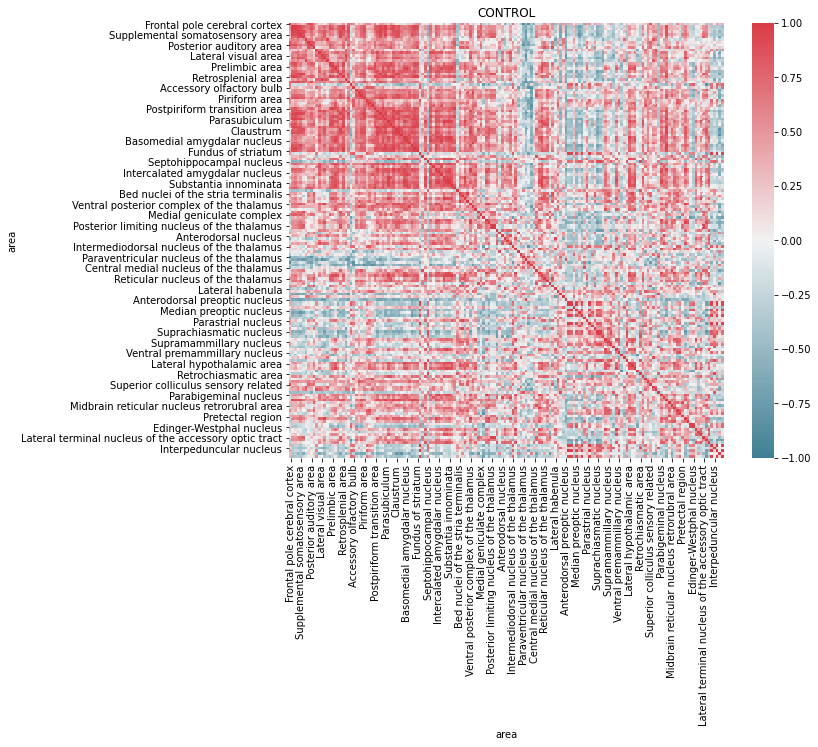

In [103]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

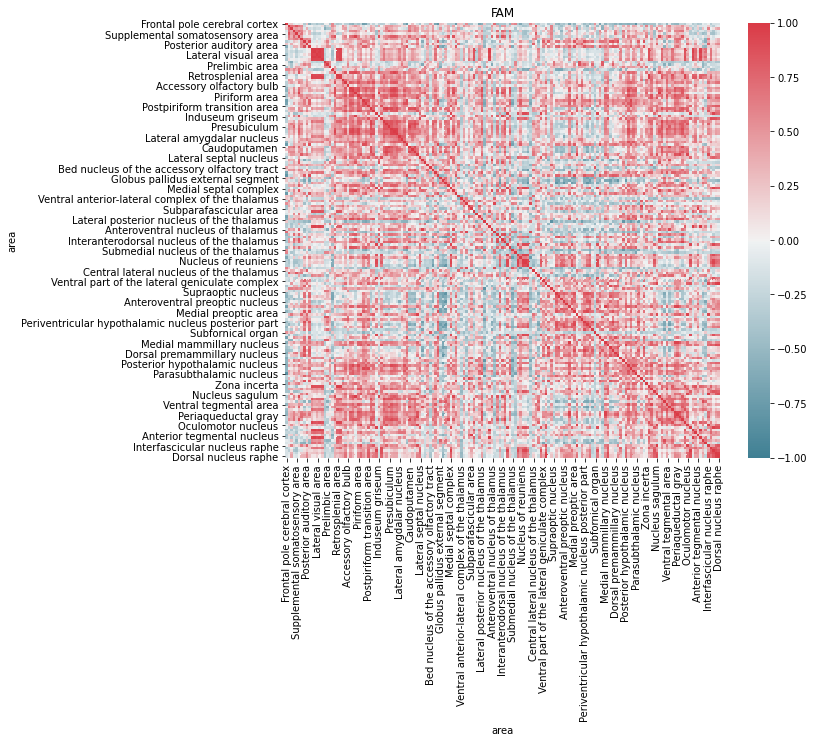

In [104]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

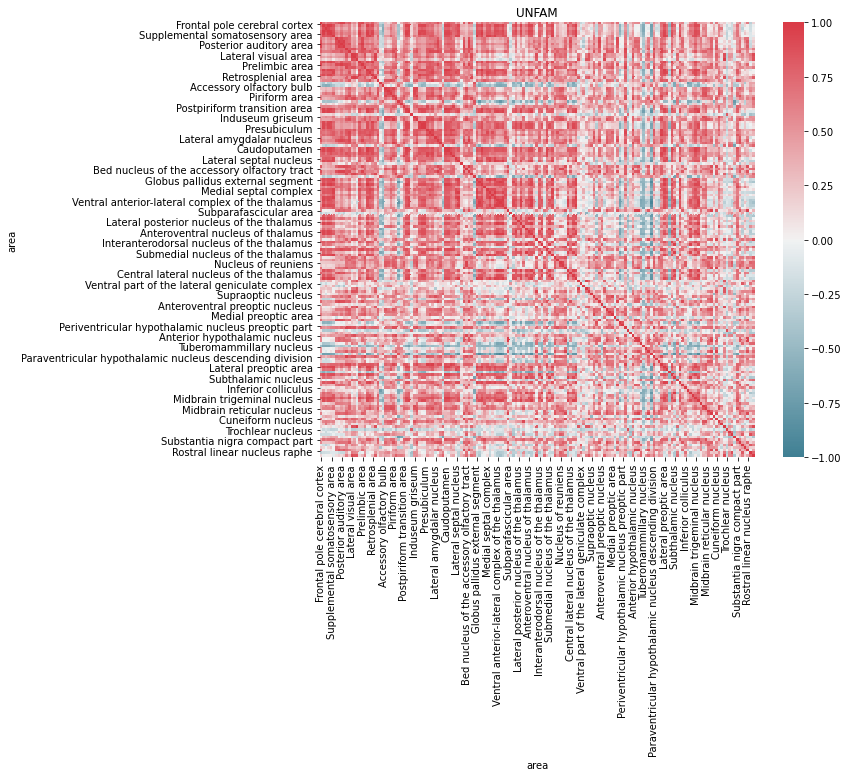

In [105]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

## Calculate energy across experimental groups

In [106]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

In [107]:
df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy],
                                        test='mannwhitneyu')


In [108]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [109]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Accessory olfactory bulb,0.000591163
Ventral premammillary nucleus,0.00566599
Medial amygdalar nucleus,0.00927166
Main olfactory bulb,0.0117338
Anteromedial nucleus,0.0147447
Cortical amygdalar area,0.0183976
Periventricular hypothalamic nucleus posterior part,0.0204442
Perirhinal area,0.0227946
Posterior auditory area,0.0280457


In [110]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Accessory olfactory bulb,0.000312169
Cortical amygdalar area,0.000431179
Periventricular hypothalamic nucleus posterior part,0.000431179
Medial amygdalar nucleus,0.000431179
Ventral premammillary nucleus,0.000591163
Piriform-amygdalar area,0.000804534
Bed nuclei of the stria terminalis,0.000804534
Medial preoptic nucleus,0.00145754
Posterior amygdalar nucleus,0.00194034


In [111]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nuclei of the stria terminalis,0.000657472
Septohippocampal nucleus,0.00206999
Triangular nucleus of septum,0.00214311
Posterior amygdalar nucleus,0.00455425
Intercalated amygdalar nucleus,0.00700964
Nucleus of the brachium of the inferior colliculus,0.00842009
Medial septal complex,0.012874
Piriform area,0.0225773
Parasubthalamic nucleus,0.0269513


In [112]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

Text(0.5, 1.0, 'CONTROL')

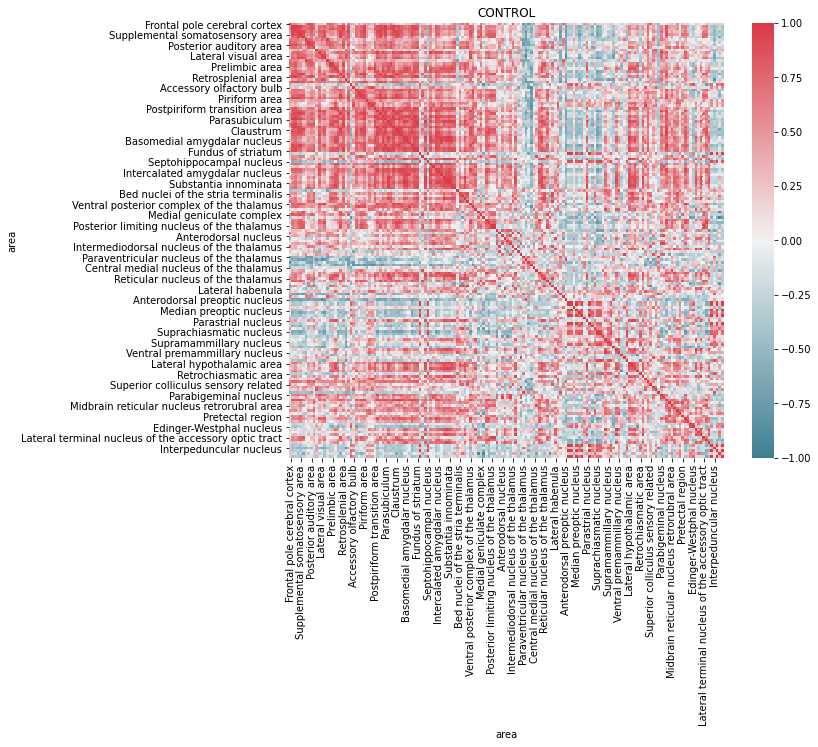

In [113]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

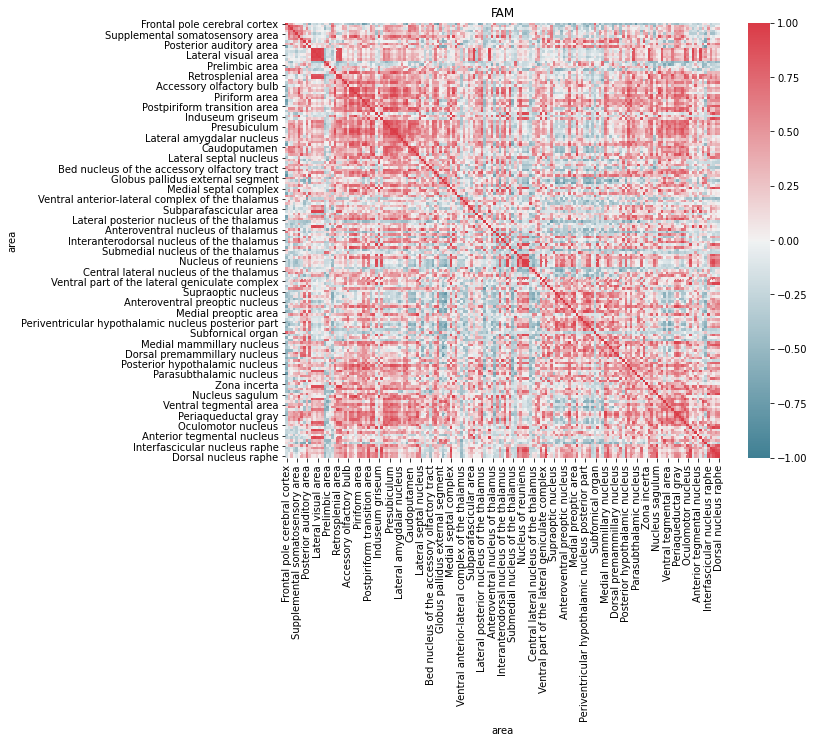

In [114]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

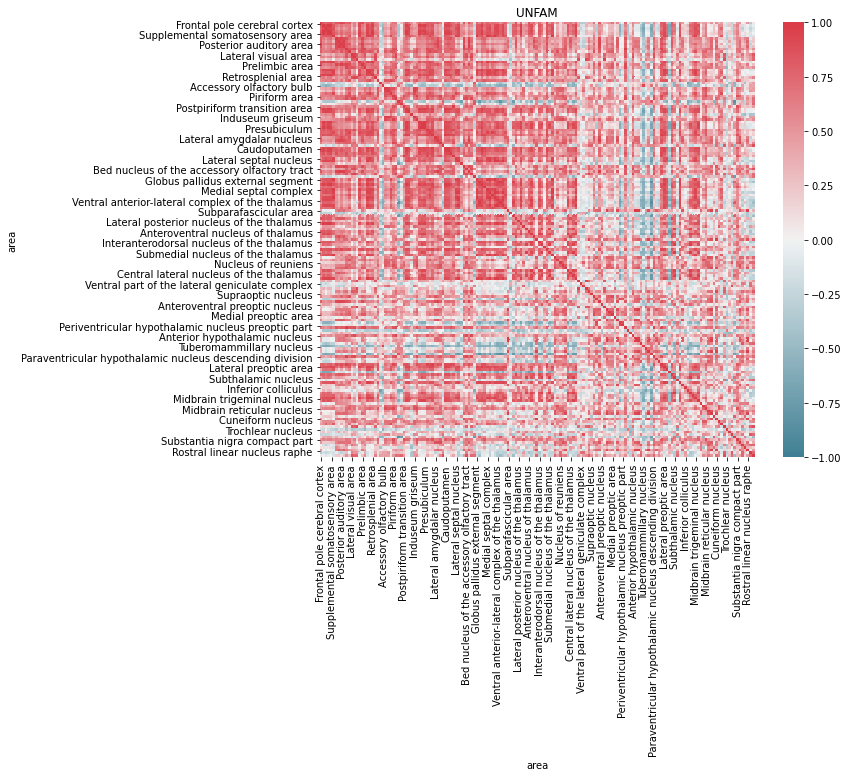

In [115]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

<AxesSubplot:xlabel='area', ylabel='number of cells'>

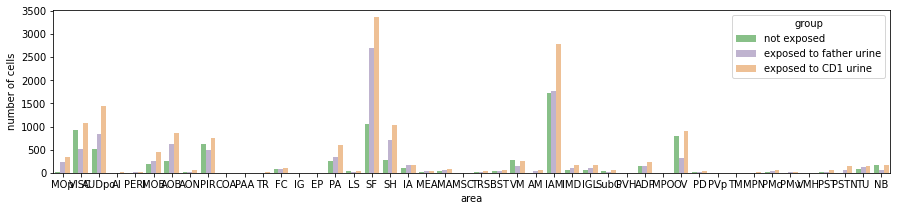

In [116]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['number of cells'] = [df_control_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['number of cells'] = [df_fam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to CD1 urine' for area in areas_ttest]
unfam['number of cells'] = [df_unfam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax)

<AxesSubplot:xlabel='area', ylabel='energy'>

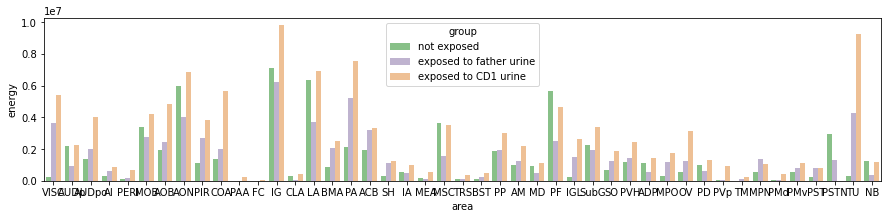

In [117]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['energy'] = [df_control_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['energy'] = [df_fam_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to CD1 urine' for area in areas_ttest]
unfam['energy'] = [df_unfam_energy.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="energy", hue="group", palette="Accent", ax=ax)

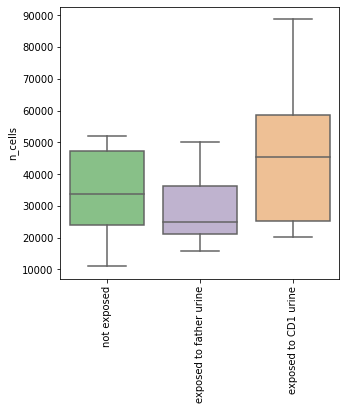

In [118]:
# stack1
subjects = subjects

control = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
fam = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
unfam = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
control['subject'] = [s for s in experimental_groups['Control']]
control['group'] = ['not exposed' for s in experimental_groups['Control']]
control['n_cells'] = [df_control_cell_count.set_index('area').sum()[s] for s in experimental_groups['Control']]

fam['subject'] = [s for s in experimental_groups['Fam']]
fam['group'] = ['exposed to father urine' for s in experimental_groups['Fam']]
fam['n_cells'] = [df_fam_cell_count.set_index('area').sum()[s] for s in experimental_groups['Fam']]

unfam['subject'] = [s for s in experimental_groups['Unfam']]
unfam['group'] = ['exposed to CD1 urine'  for s in experimental_groups['Unfam']]
unfam['n_cells'] = [df_unfam_cell_count.set_index('area').sum()[s] for s in experimental_groups['Unfam']]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
sns.boxplot(
    data=with_father,
    x="group", y="n_cells", palette="Accent", ax=ax)
ax.set_xlabel('')
ax.tick_params(axis='x', labelrotation=90)